In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import defaultdict

sns.set_theme(palette="bright", style="whitegrid")
matplotlib.rcParams['font.serif'] = "cmb10"
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

In [2]:
color_mapping = {
    k: v for k, v in zip(
        ["CBL-1", "Bufboss-1", "Bifrost-1", "BSBWT-1-0.5", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        sns.color_palette())
}
name_mapping = {
 k: v for k, v in zip(
        ["CBL-1", "Bufboss-1", "Bifrost-1", "BSBWT-1-0.5", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        ["CBL",  "Bufboss",   "Bifrost 1t", "DSBWT 1t 0.5G", "DSBWT 4t 0.5G", "DSBWT 16t 4G", "Bifrost 32t", "DSBWT 32t 30G"])
}  
marker_mapping = {
 k: v for k, v in zip(
        ["CBL-1", "Bufboss-1", "Bifrost-1", "BSBWT-1-0.5", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        ["o", "X", "s", "^", ">", "<", "d", "v"])
}  

In [3]:
def read_res(path):
    data = defaultdict(list)
    sizes = []
    added = []
    time = 0
    rss = 0
    ds_type = None
    threads = 0
    file_count = 0
    buf_size = 0
    with open(path) as in_f:
        for line in in_f:
            if "CBL/target/release" in line:
                ds_type = "CBL"
                threads = 1
                file_count = int(line.split("/")[-1].split(".")[0])
            elif "bufboss/bin/" in line:
                ds_type = "Bufboss"
                threads = 1
            elif "bifrost/build/bin" in line:
                ds_type = "Bifrost"
            elif "Buffered_SBWT" in line:
                ds_type = "BSBWT"
            elif line.startswith("threads = "):
                threads = int(line.split()[-1])
            elif line.startswith("max buffer size"):
                buf_size = float(line.split()[-2])
            elif "maxresident" in line:
                for field in line.split():
                    if "elapsed" in field:
                        f_s = field[:-7].split(':')
                        time = int(f_s[-2]) * 60 + float(f_s[-1])
                        if len(f_s) > 2:
                            time += int(f_s[0]) * 60 * 60
                    elif "maxresident" in field:
                        rss = int(field[:-13])
                        rss /= 1024
                        if ds_type == "BSBWT":
                            data[f"{ds_type}-{threads}-{buf_size}"].append((time, rss))
                        else:
                            data[f"{ds_type}-{threads}"].append((time, rss))
            elif threads == 1 and line.startswith("Saw "):
                elems = int(line.split()[1]) // 2
                sizes.append(elems)
            elif threads == 1 and line.startswith("Added"):
                elems = int(line.split()[1]) // 2
                added.append(elems)
    return {
        "offered": sizes, 
        "added": added, 
        "data": data
    }

In [4]:
def plot_time_and_space(data, sizes, title, name=None):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in sorted(data.items()):
        plt.plot(sizes, [vv[0] for vv in v], color=color_mapping[k], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.title("Construction time")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in sorted(data.items()):
        plt.plot(sizes, [vv[1] for vv in v], color=color_mapping[k], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers")
    plt.ylabel("RSS (M)")
    plt.legend()
    plt.title("Construction space")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    plt.show()

In [5]:
def plot_time_and_mem_vs_best(data, sizes, title, name=None):
    control = ([], [])
    for z in zip(*data.values()):
        control[0].append(min(v[0] for v in z))
        control[1].append(min(v[1] for v in z))
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in sorted(data.items()):
        plt.plot(sizes, [vv[0] / s for vv, s in zip(v, control[0])], color=color_mapping[k], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers")
    plt.ylabel("Time compared to best")
    plt.legend()
    plt.title("Construction time")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in sorted(data.items()):
        plt.plot(sizes, [vv[1] / s for vv, s in zip(v, control[1])], color=color_mapping[k], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers")
    plt.ylabel("RSS compared to best")
    plt.legend()
    plt.title("Construction space")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    plt.show()

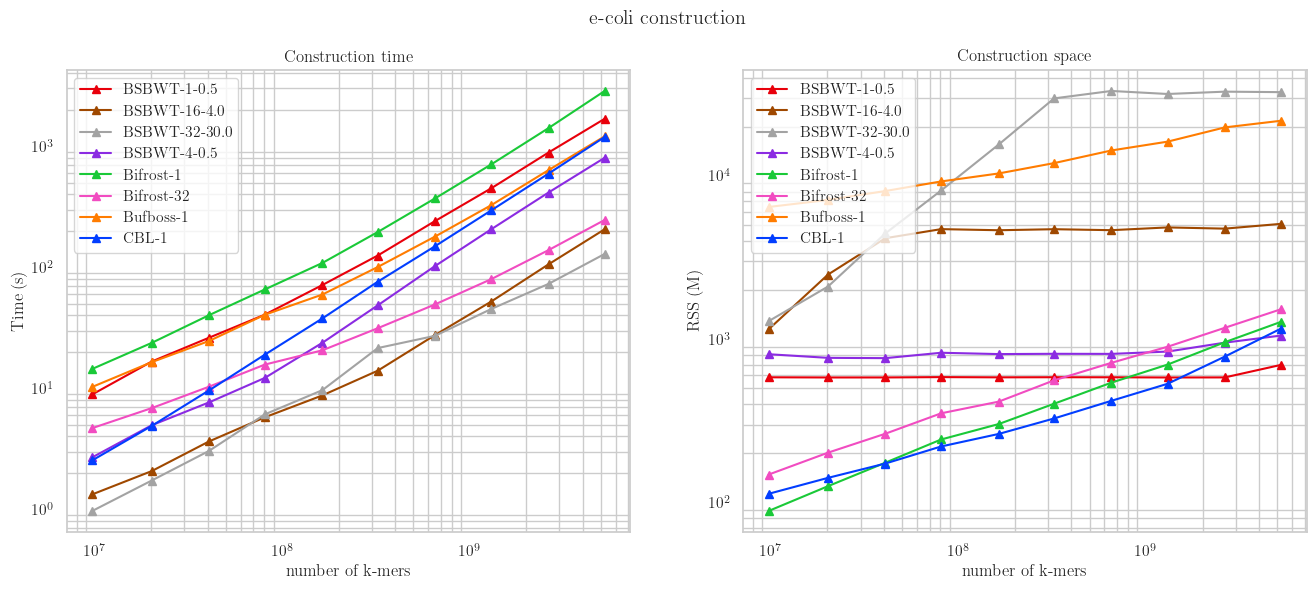

In [6]:
coli_res = read_res("../bbb_res/build_coli.txt")
plot_time_and_space(coli_res["data"], coli_res["offered"], "e-coli construction", "build_e-coli_total.pdf")

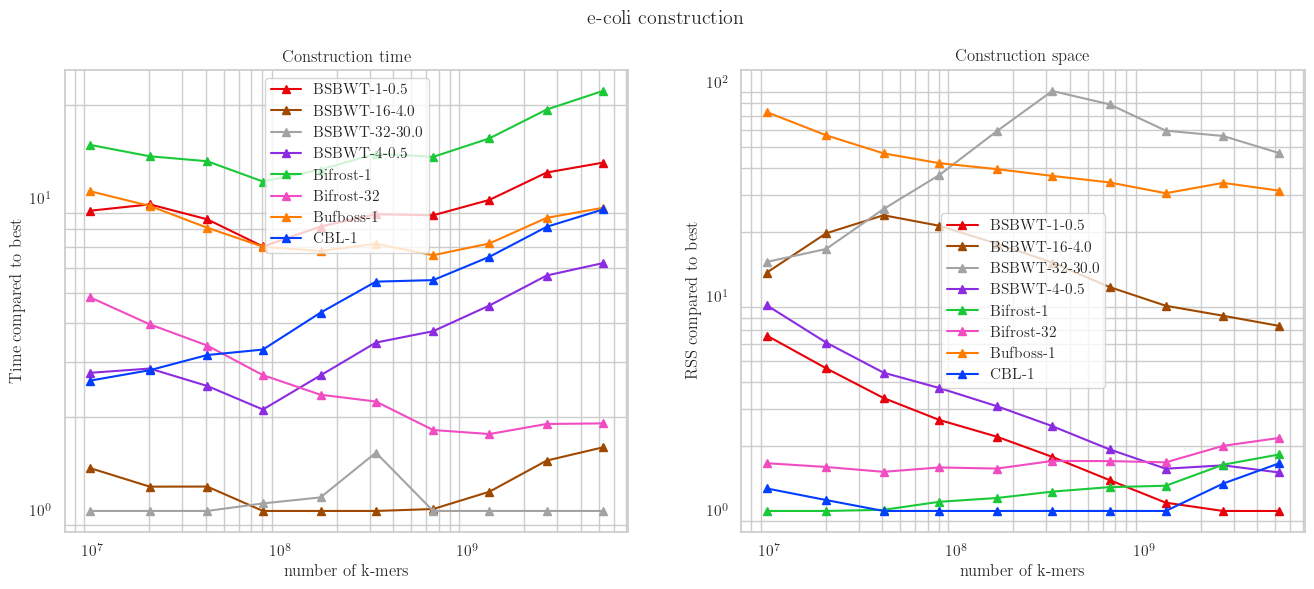

In [7]:
plot_time_and_mem_vs_best(coli_res["data"], coli_res["offered"], "e-coli construction", "build_e-coli_comp.pdf")

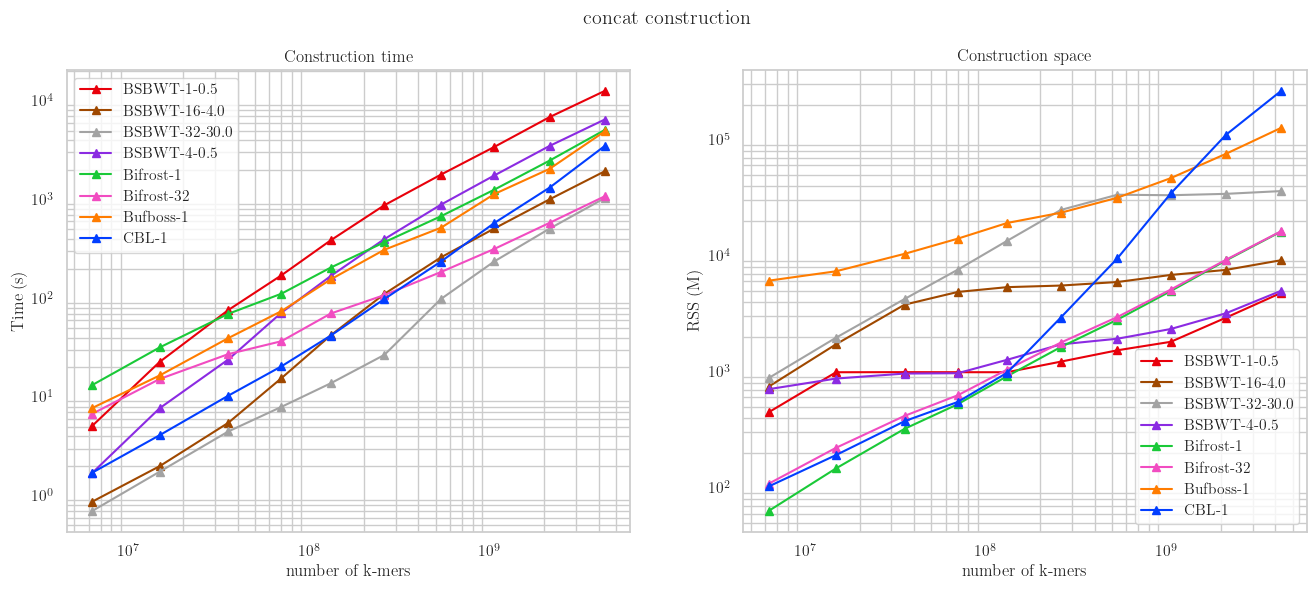

In [8]:
concat_res = read_res("../bbb_res/build_concat.txt")
plot_time_and_space(concat_res["data"], concat_res["offered"], "concat construction", "build_concat_total.pdf")

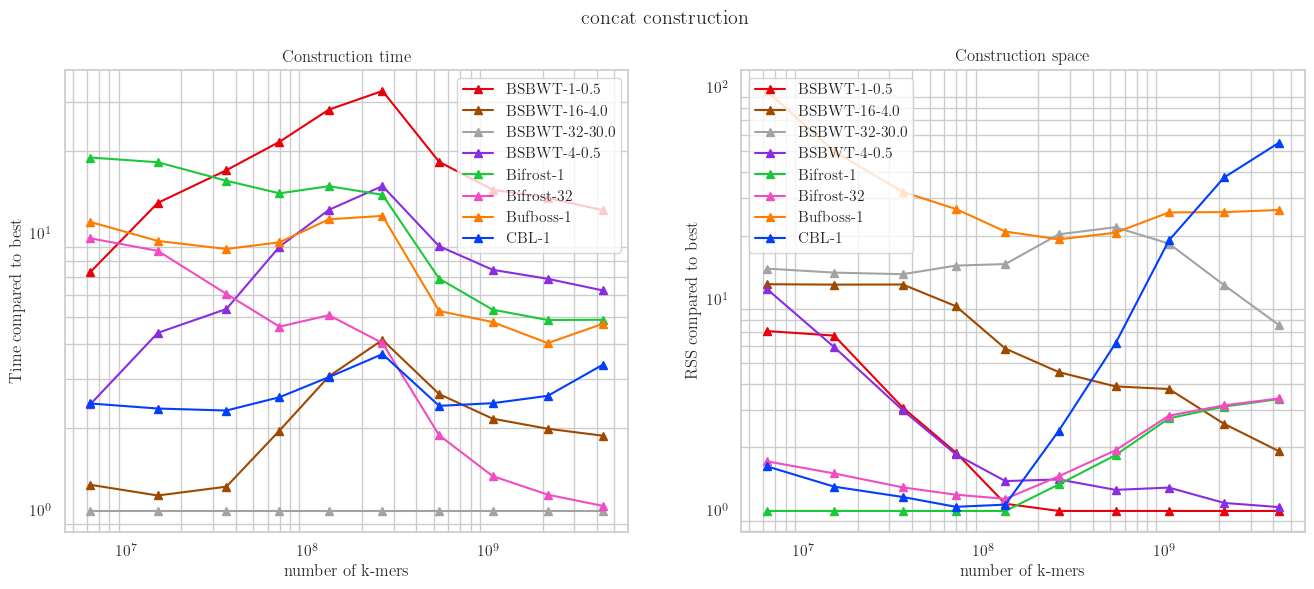

In [9]:
plot_time_and_mem_vs_best(concat_res["data"], concat_res["offered"], "concat construction", "build_concat_comp.pdf")

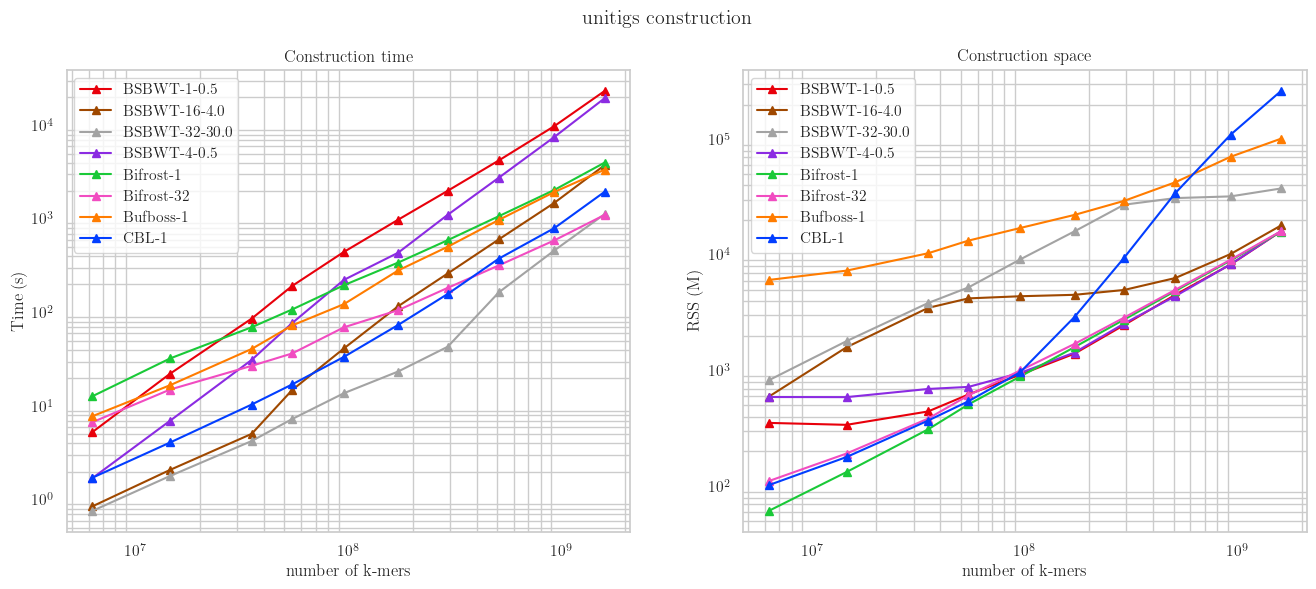

In [10]:
uni_res = read_res("../bbb_res/build_uni.txt")
plot_time_and_space(uni_res["data"], uni_res["offered"], "unitigs construction", "build_uni_total.pdf")

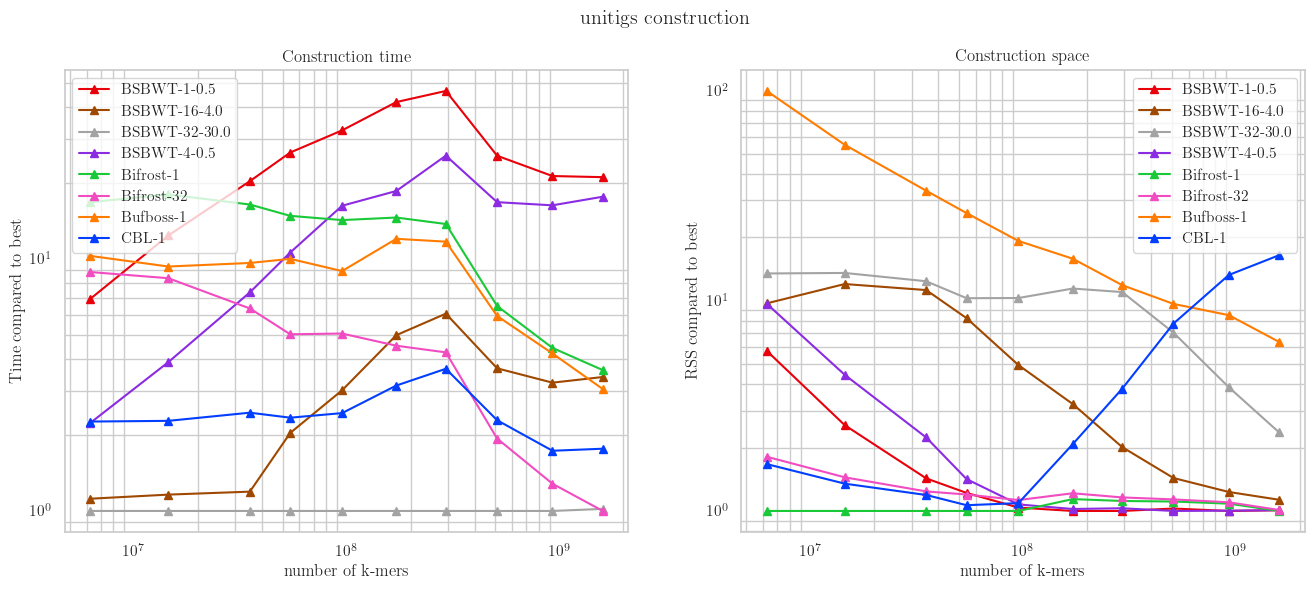

In [11]:
plot_time_and_mem_vs_best(uni_res["data"], uni_res["offered"], "unitigs construction", "build_uni_comp.pdf")

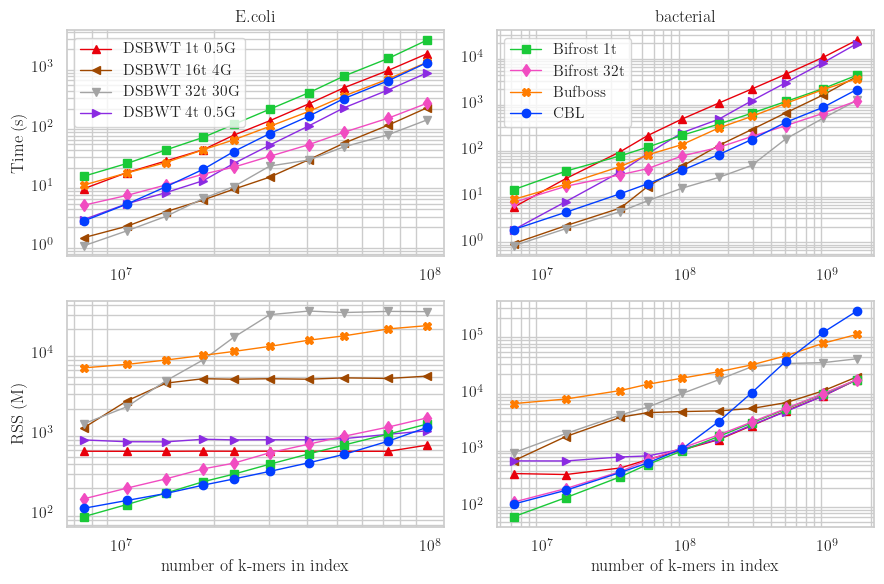

In [12]:
plt.figure(figsize=(9, 6))

for i, (ds, name) in enumerate(zip([coli_res, uni_res], ["E.coli", "bacterial"])):
    plt.subplot(2, 2, i + 1)
    handles = []
    for k, v in sorted(ds["data"].items()):
        handles += plt.plot(ds["added"], [vv[0] for vv in v], linewidth=1,
            color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    if i == 0:
        plt.ylabel("Time (s)")
        plt.legend(handles=handles[:4])
    else:
        plt.legend(handles=handles[4:])
    plt.title(name)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(2, 2, i + 3)
    for k, v in sorted(ds["data"].items()):
        plt.plot(ds["added"], [vv[1] for vv in v], linewidth=1,
             color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers in index")
    if i == 0:
        plt.ylabel("RSS (M)")
    #plt.legend()
    plt.grid(which='major')
    plt.grid(which='minor')
plt.tight_layout()
plt.savefig("build_time_and_space.pdf", bbox_inches="tight")
#plt.show()

In [13]:
[a/ b for a, b in zip(coli_res["offered"], uni_res["offered"])]

[1.5549442460647698,
 1.3869984683341559,
 1.1608086545880483,
 1.4869401398398332,
 1.7211580209769244,
 1.887727083728342,
 2.2307440579037676,
 2.555295017581601,
 2.8357264557107813,
 3.275791701763933]

In [14]:
[a / b for a, b in zip(uni_res["added"], uni_res["offered"])]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [15]:
one

NameError: name 'one' is not defined